In [1]:
def pxlocal(line, cell):
    ip = get_ipython()
    ip.run_cell_magic("px", line, cell)
    ip.run_cell(cell)
get_ipython().register_magic_function(pxlocal, "cell")

In [2]:
import subprocess
import ipyparallel as ipp
import time
from IPython.display import clear_output
from agent import Agent
import numpy as np
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output

class Generation:
    
    num_engines = None
    num_survivors = None
    agents_per_engine = None
    size = None
    agents = None
    history = None
    new_ID = None
    rc = None
    
    
    def __init__(self, size, num_survivors, freq = .25, intensity = .25, wait = 10):
        self.size = size
        self.num_survivors = num_survivors
        self.agents = []
        self.history = []
        
        self.start_engines(num_survivors)
        
        time.sleep(wait)
        for ID in range(self.size):
            self.agents.append(Agent(ID = ID, freq = freq, intensity = intensity))
        self.new_ID = ID + 1
        
        self.rc = ipp.Client()
    
    def start_engines(self, num_engines):
        self.num_engines = num_engines
        self.agents_per_engine = self.size//self.num_engines
        
        subprocess.Popen(["ipcluster", "stop"])
        time.sleep(5)
        subprocess.Popen(["ipcluster", "start", "-n={:d}".format(num_engines)])
     
    def same_as_parent(self, pos):
        ancestor_pos = pos//self.agents_per_engine*self.agents_per_engine
        return ancestor_pos != pos and self.agents[ancestor_pos].total_reward == self.agents[pos].total_reward
        
    def get_ranking(self, similar_penalty = False):
        ranking = []
        for pos, agent in enumerate(self.agents):
            reward = agent.get_reward()
            if self.same_as_parent(pos) and similar_penalty:
                reward/=2
            ranking.append((pos, reward))
        return ranking
    
    def get_survivors_pos(self):
        ranking = self.get_ranking(similar_penalty = True)
        survivors_ranking = sorted(ranking, reverse = True, key = lambda key: key[1])[:self.num_survivors]
        return sorted(list(zip(*survivors_ranking))[0])
    
    def replace(self):
        survivors_pos = self.get_survivors_pos()
        for new_pos, old_pos in enumerate(survivors_pos):
            self.agents.insert(new_pos*self.agents_per_engine, self.agents.pop(old_pos))
    
    def derive(self, parent_pos, child_pos):
        self.agents[child_pos].copy_model(self.agents[parent_pos], new_ID = self.new_ID)
        self.new_ID += 1
        self.agents[child_pos].mutate()
        self.agents[child_pos].total_reward = None
        
    def parallel_run(self, max_steps = 500):
        dview = self.rc[:]
        dview.scatter('agents', self.agents)
        dview.push({'max_steps': max_steps})
        %px rewards = [agent.get_reward() for agent in agents]
        #%px rewards = [print(agent) for agent in agents]
        return dview.gather('rewards').get()    
    
    
    def replication(self, verbose = False):
        for e in range(self.num_engines):
            for a in range(1, self.agents_per_engine):
                print(e*self.agents_per_engine, e*self.agents_per_engine + a)
                self.derive(e*self.agents_per_engine, e*self.agents_per_engine + a)
    
    def evolution_step(self, max_steps = 500, chronometer = False, plot = False):
        start_time = time.time()
        if self.num_engines != None:
            rewards = self.parallel_run(max_steps = max_steps)
            
        for agent, reward in zip(self.agents, rewards):
            agent.reward = reward
            
        end_time = time.time()
        
        if chronometer:
            print('Run time:', end_time - start_time)
       
        self.history.append(sorted(rewards, reverse = True))
        
        start_time = time.time()
        self.replace()
        self.replication(True)
        end_time = time.time()
        
        if chronometer:
            print('Replication time:', end_time - start_time)
            
        clear_output(wait = True)
        if plot:
            
            plt.plot(self.history)
            plt.show()

Using TensorFlow backend.


In [3]:
generation = Generation(size = 20, num_survivors = 4, wait = 20)

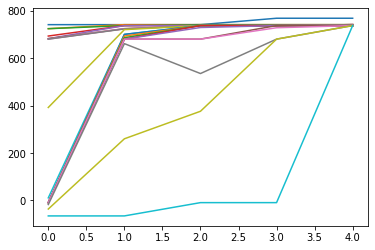

In [ ]:
for i in range(100):
    generation.evolution_step(max_steps = (i//10 + 1)*100, chronometer = True, plot = True)

In [ ]:
generation.agents[0].lineage

In [ ]:
generation.agents[1].lineage